In [84]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns



In [85]:
import findspark
findspark.init()
findspark.find()

'C:\\Program Files\\Spark\\spark-3.5.1-bin-hadoop3'

In [86]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("My Spark App") \
    .getOrCreate()

# EDA

In [87]:
songs_df = spark.read.csv("cleaned_songs.csv", header=True, inferSchema=True)

print(songs_df.count())

18184


## Language Distribution 

Number of English songs: 15395


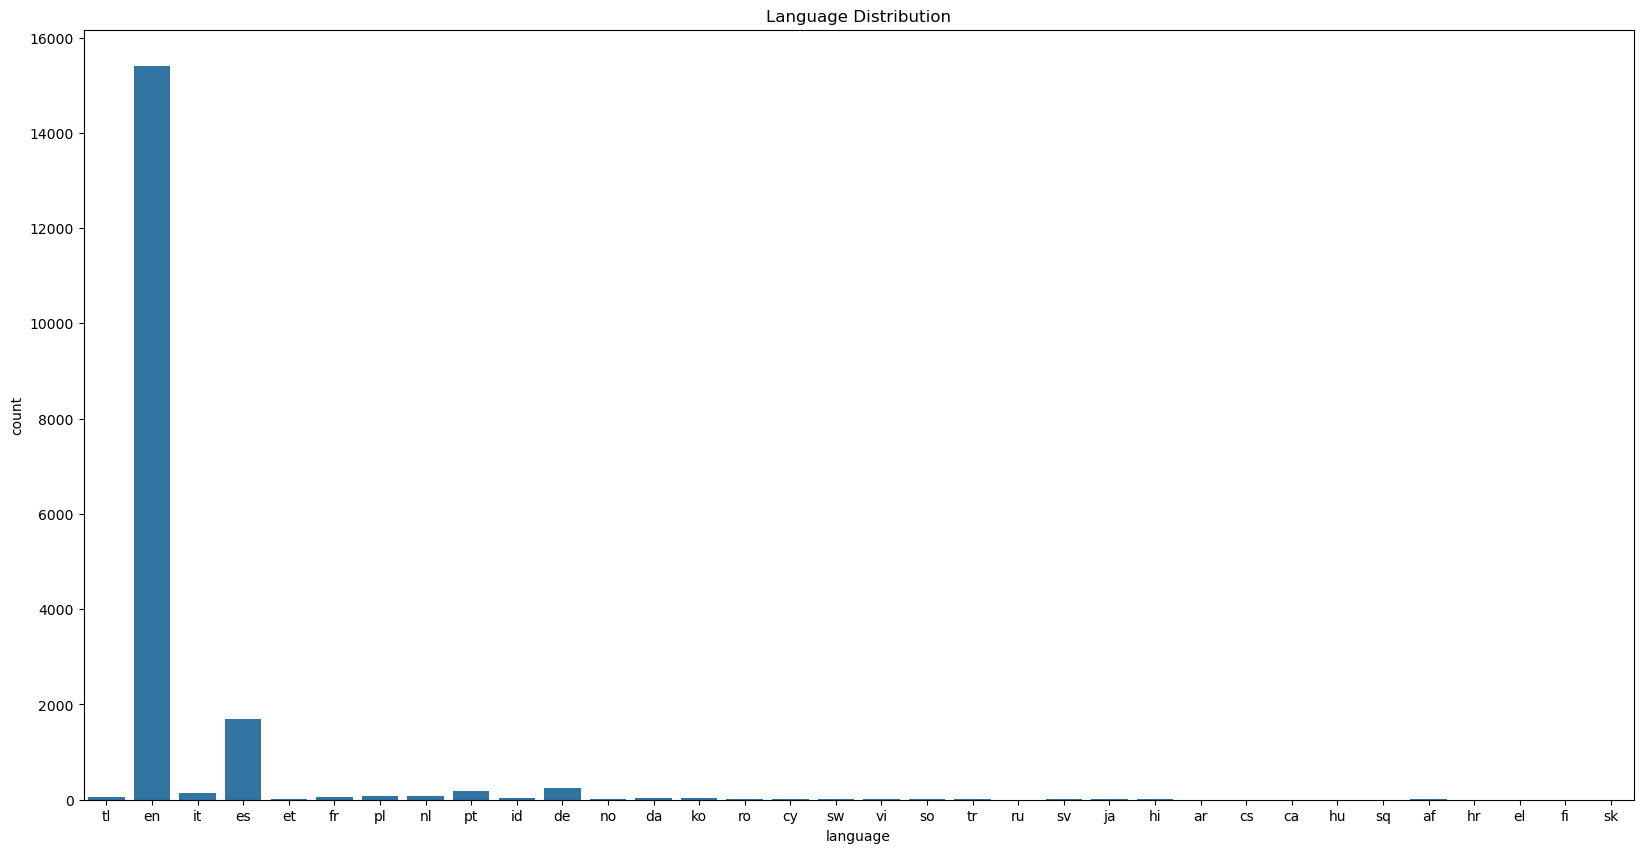

In [88]:
# language distribution
fig,ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x='language', data=songs_df.toPandas())
ax.title.set_text('Language Distribution')
print (f"Number of English songs: {songs_df.filter(songs_df['language'] == 'en').count()}")



In [89]:
# #remove non-english songs as they are under-represented
# songs_df = songs_df.filter(songs_df['language'] == 'en')

Number of Non English songs: 2789


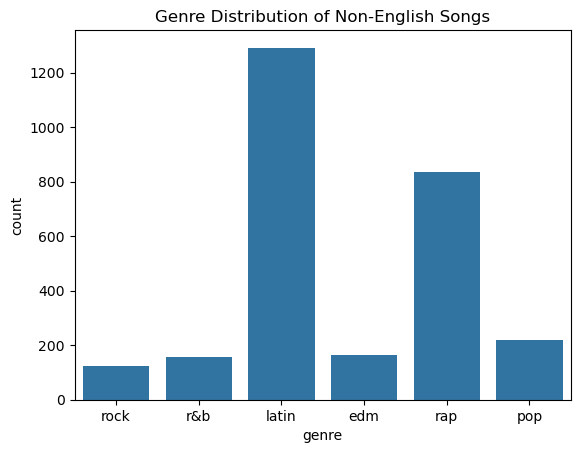

In [90]:
# genre distribtution of non-english songs
non_english_songs_df = songs_df.filter(songs_df['language'] != 'en')
ax = sns.countplot(x='genre', data=non_english_songs_df.toPandas())

ax.title.set_text('Genre Distribution of Non-English Songs')


print (f"Number of Non English songs: {non_english_songs_df.count()}")

In [91]:
#print number of songs per genre

# Count the number of songs per genre
genres = songs_df.groupBy("genre").count()

# Display the results
display(genres.toPandas().sort_values(by=['count'], ascending=False))

,genre,count
1,pop,3956
4,rock,3512
3,rap,3338
0,r&b,3308
5,latin,2148
2,edm,1922


In [92]:
from pyspark.sql import functions as F
features = ["danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms"]

# transform genre column to string array 
genres = songs_df.select("genre").distinct().select(F.collect_list('genre')).first()[0]




## Correlation Matrix

<Axes: >

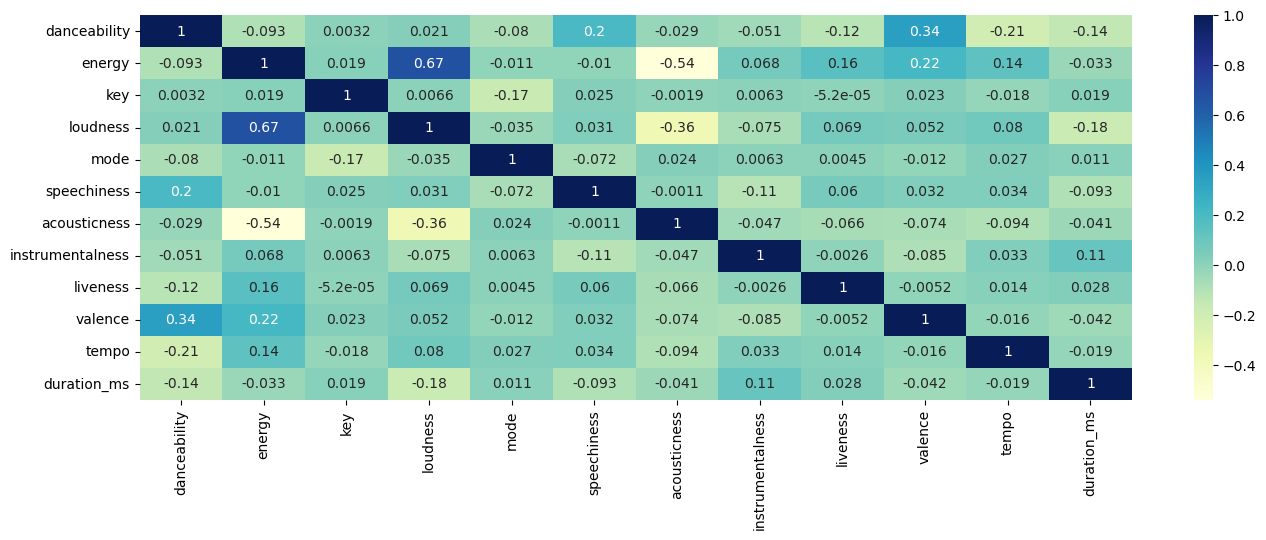

In [93]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# make sure that all this features have numeric values
for feature in features:
    songs_df = songs_df.filter(col(feature).cast("float").isNotNull() | col(feature).cast("int").isNotNull() )



# draw correlation matrix

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=features, outputCol=vector_col)
df_vector = assembler.transform(songs_df.select(features)).select(vector_col)

# get correlation matrix
corr_matrix_df = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray()

plt.figure(figsize=(16, 5))
sns.heatmap(
    corr_matrix_df,
    xticklabels=features,
    yticklabels=features,
    cmap="YlGnBu",
    annot=True,
)

The only 2 features that have some kind of correlation are <b>loudness</b> and <b>energy</b>

# Relations

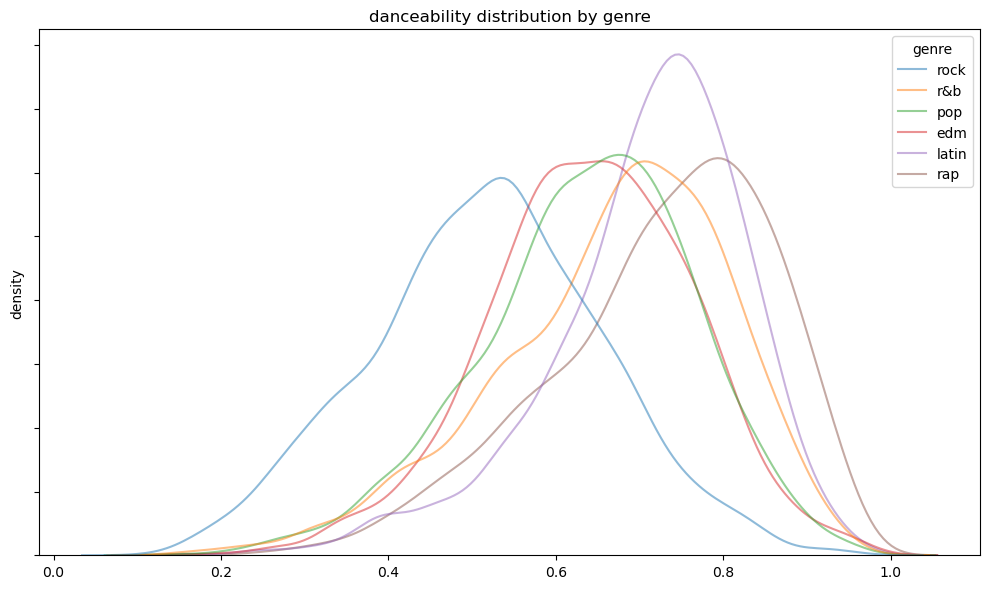

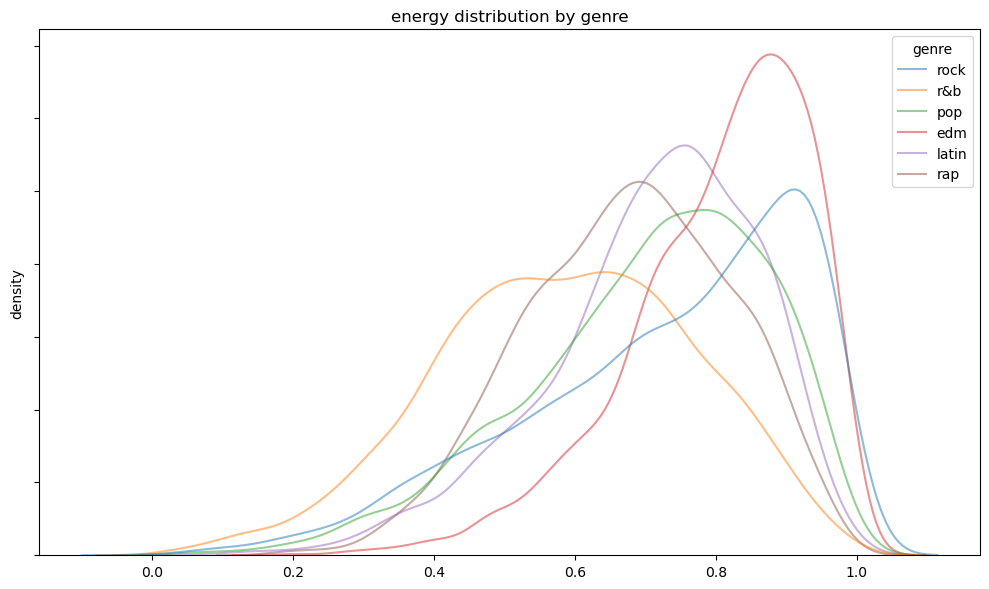

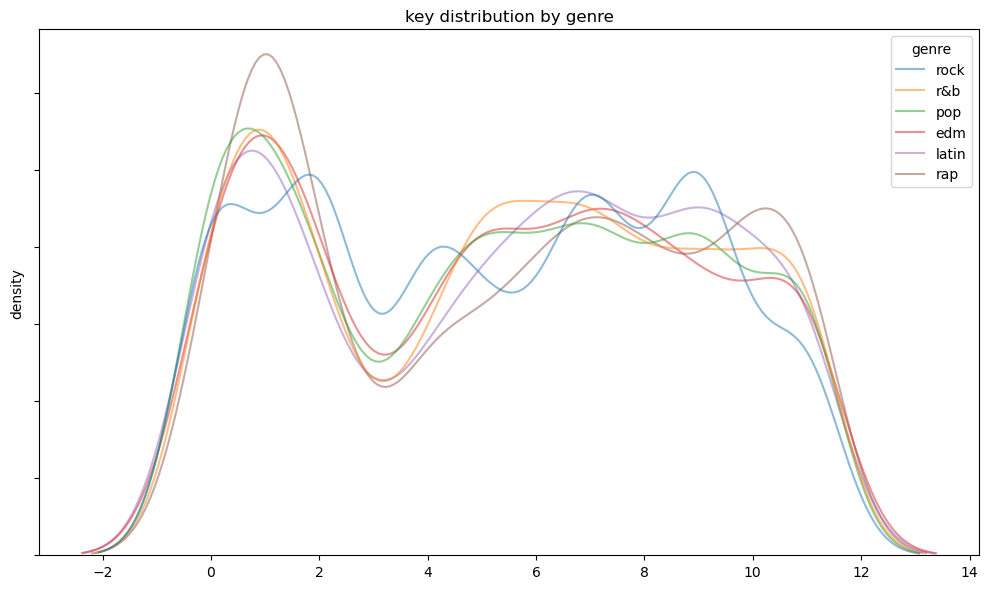

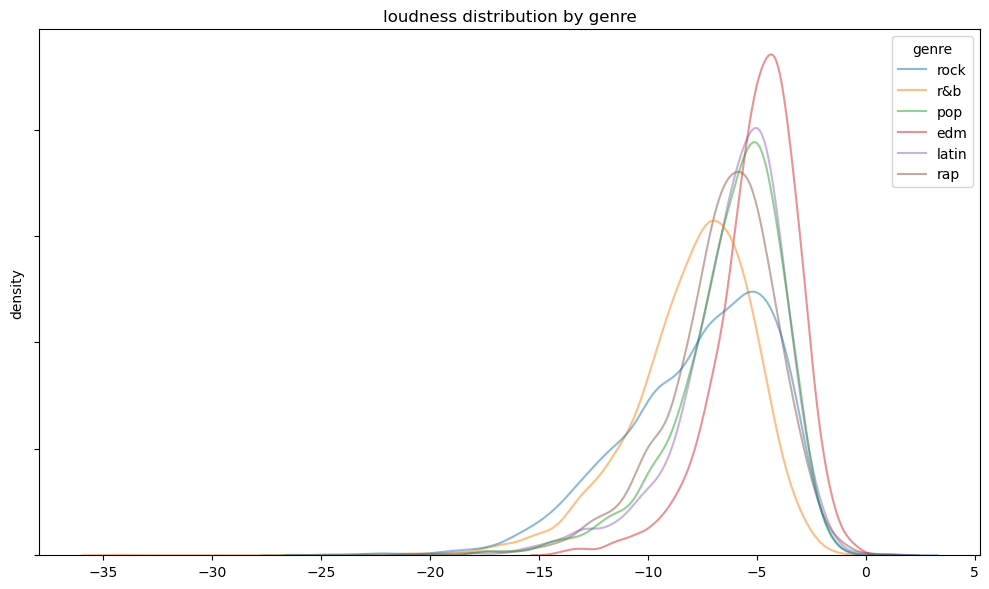

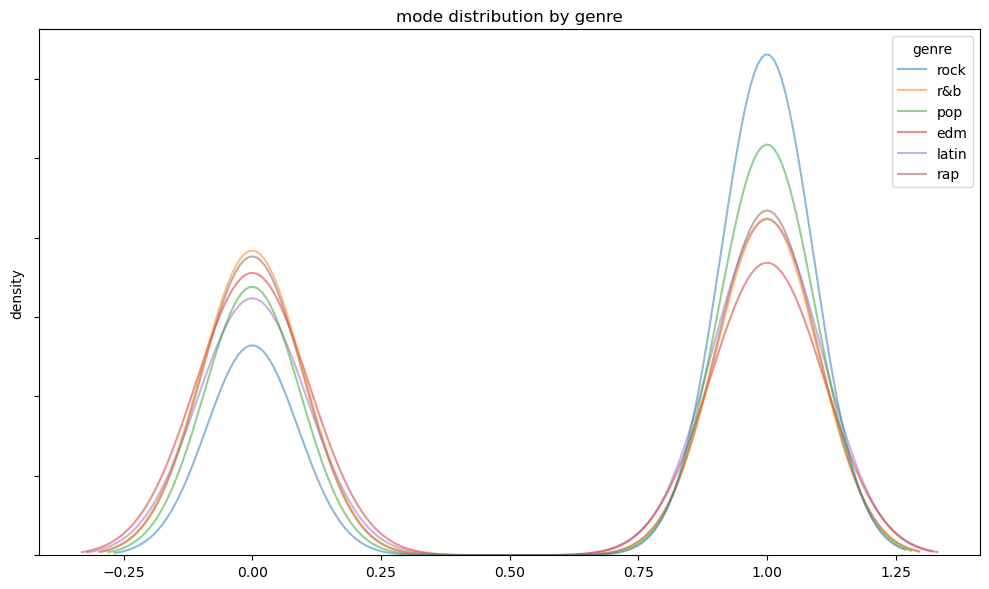

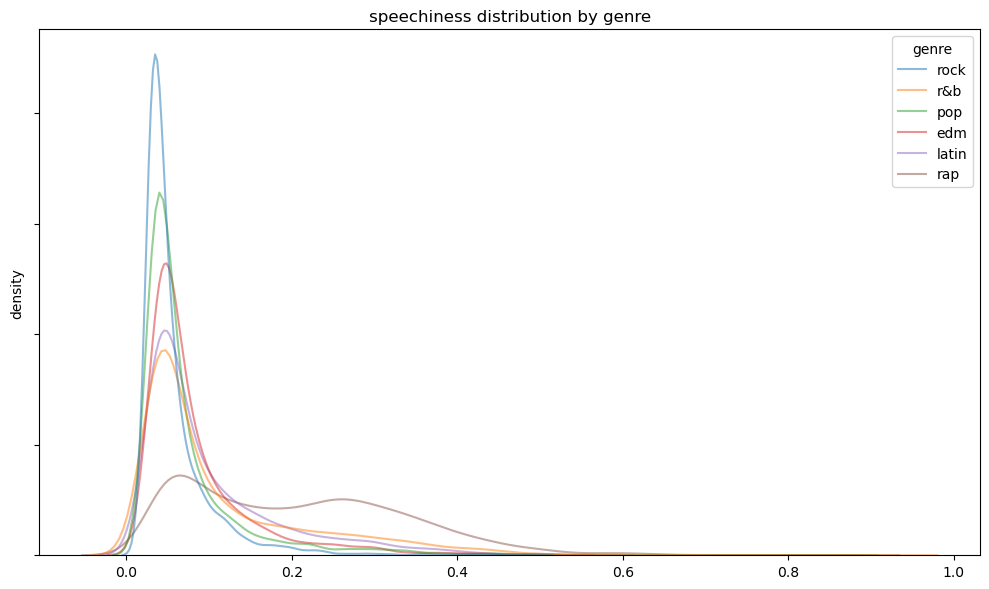

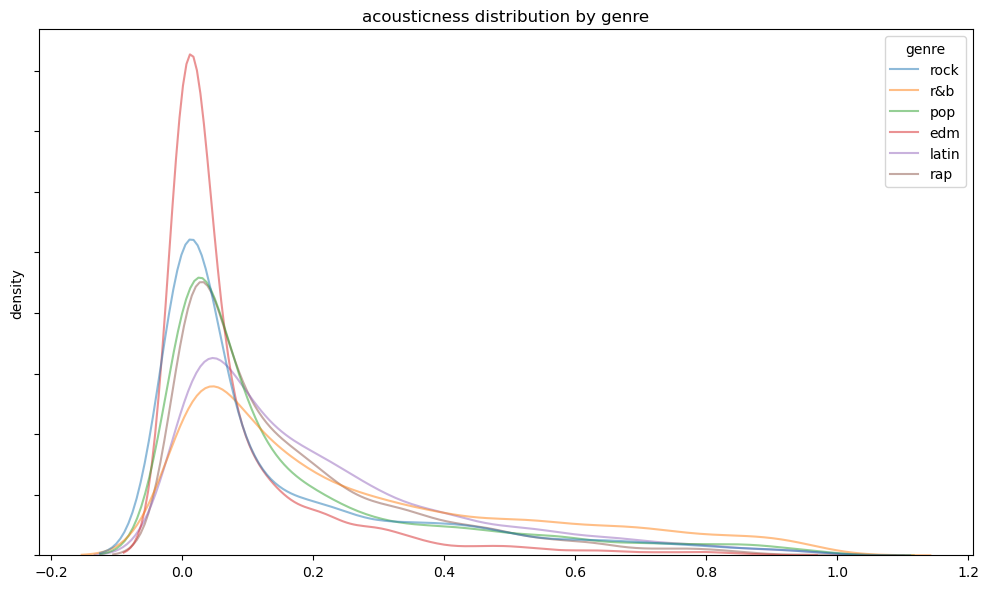

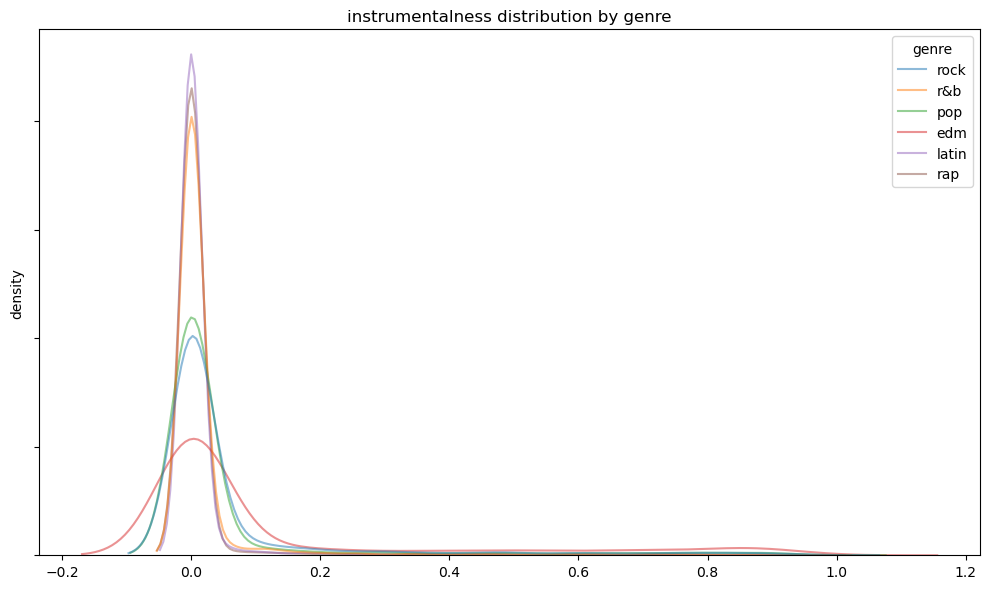

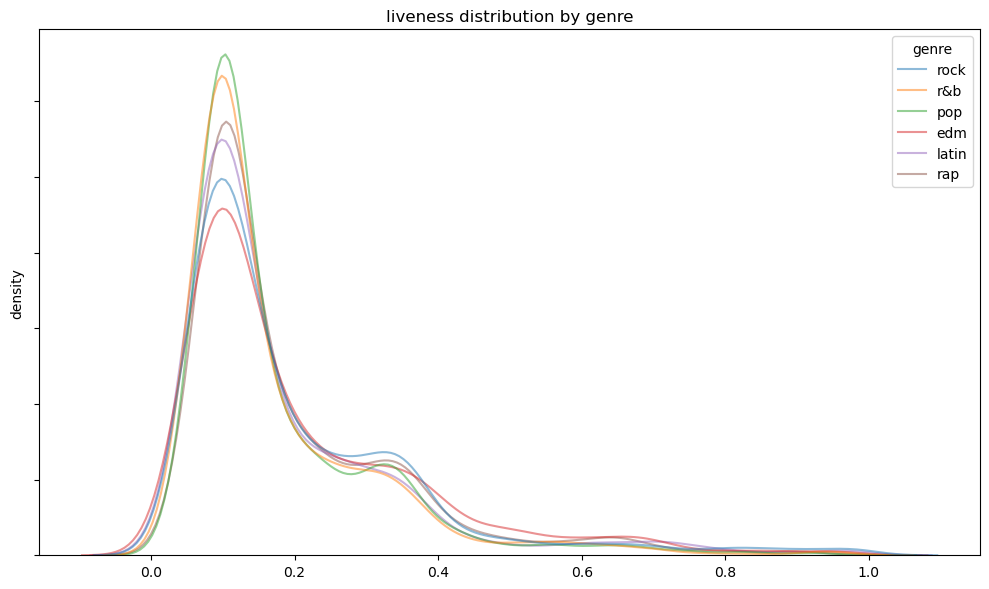

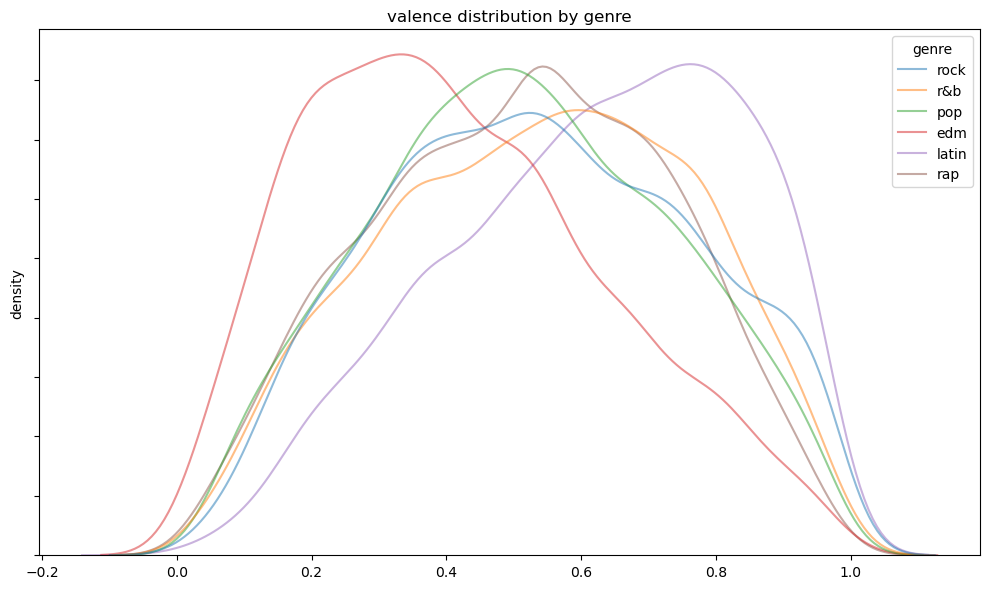

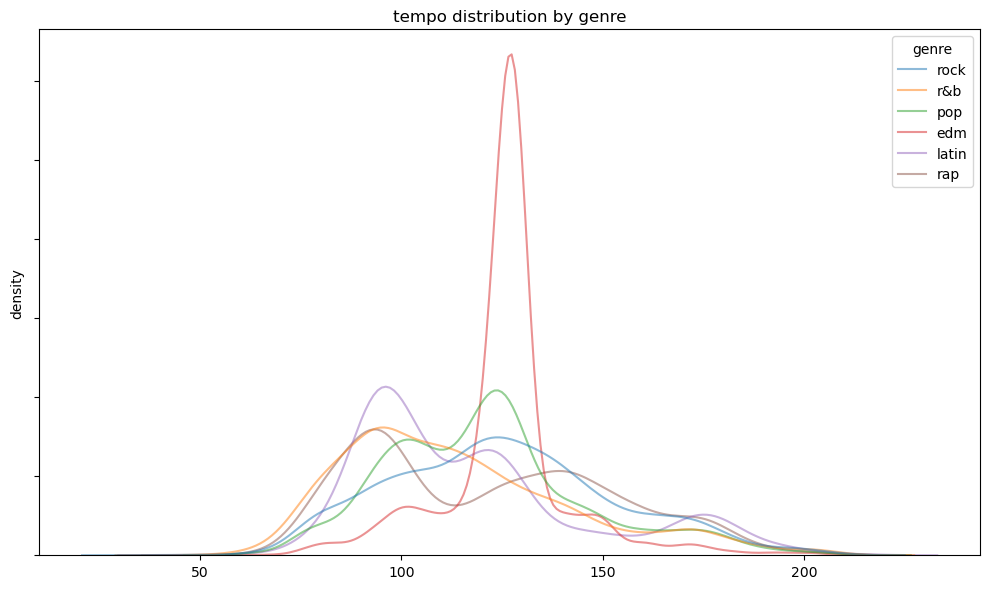

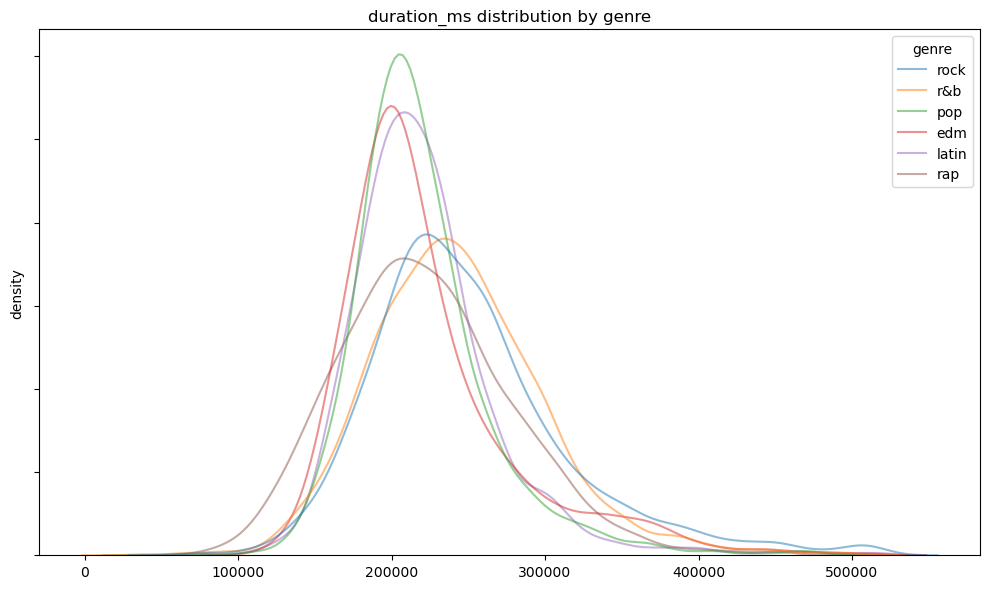

In [94]:
# Selecting columns 'genre' and feature_names
selected_data = songs_df.select(["genre"] + features)

# Converting the DataFrame to Pandas for plotting with seaborn
pandas_df = selected_data.toPandas()


for feature in features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=pandas_df, x=feature, hue="genre", alpha=0.5, common_norm=False)
    plt.title(f"{feature} distribution by genre")
    plt.xlabel("")
    plt.ylabel("density")
    plt.gca().set_yticklabels([])
    plt.tight_layout()
    plt.show()



